In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import gym

In [69]:
# master class that performs environment interaction and learning
class Master():
    def __init__(self,
                 env_name,
                 n_actor,
                 n_critic,
                 n_place,
                 dt,
                 V_0,
                 tau_r,
                 stepSize=1,
                 actor_lr=0.05,
                 critic_lr=0.2):
        
        # gym
        self.env = gym.make(env_name)
        if type(self.env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = self.env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = self.env.action_space.shape[0]
            self.discrete_actions = False
            
        if env_name == 'Pendulum-v0':
            self.F_max = 2
            self.actor_directions = 2 * self.F_max * np.arange(n_actor) / n_actor - self.F_max
        
        self.state_dim = self.env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = self.env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0
        
        self.V_0 = V_0
        self.tau_r = tau_r
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.place_actor_weights = np.random.normal(loc=0.5, scale=0.1, size=(n_actor, n_place))
        self.place_critic_weights = np.random.normal(loc=0.5, scale=0.1, size=(n_critic, n_place))
        self.w_min = 0
        self.w_max = 3
    
    def step(self, t, action):
        if int(t / self.dt) % self.stepsize != 0:
            return

        self.state, self.reward, self.done, _ = self.env.step(action)
        self.totalReward += self.reward
        if self.done:
#             print('done')
            self.reward = -5 # penalize end of episode
            self.totalReward += self.reward
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0

    def calc_td_error(self, t, critic_rates):
        return np.mean(critic_rates) - self.V_0/self.tau_r + self.reward

    def outer(self, t, x):
        X_conv_eps = x[:n_place]
        Y = x[n_place:]
        return np.outer(Y, X_conv_eps).flatten()
    
    def actor(self, t, x):
        dVdw = x[:n_place * n_actor].reshape(n_actor, n_place)
        place_spikes = x[n_place * n_actor:-1]
        td_error = x[-1]
#         print('actor:', np.mean(dVdw), np.sum(dVdw))
        self.place_actor_weights += self.actor_lr * td_error * dVdw
        self.place_actor_weights = np.clip(self.place_actor_weights, a_min=self.w_min, a_max=self.w_max)

        return np.dot(self.place_actor_weights, place_spikes)
        
    def critic(self, t, x):
        dVdw = x[:n_place * n_critic].reshape(n_critic, n_place)
        place_spikes = x[n_place * n_critic:-1]
        td_error = x[-1]
#         print('critic:', np.mean(dVdw), np.sum(dVdw))
        self.place_critic_weights += self.critic_lr * td_error * dVdw
        self.place_critic_weights = np.clip(self.place_critic_weights, a_min=self.w_min, a_max=self.w_max)
        
        return np.dot(self.place_critic_weights, place_spikes)

    def select_action(self, t, actor_rates):
        rate_sum = np.sum(actor_rates)
        if rate_sum == 0: return 0
        return np.dot(actor_rates, self.actor_directions) / rate_sum
    
    def calc_value(self, t, critic_rates):
        return np.mean(critic_rates) + self.V_0
    
    def test_actor(self, t, x):
        a = x[:n_actor]
        b = x[n_actor:]
        return np.sum((a-b)**2)
    
    def test_critic(self, t, x):
        a = x[:n_critic]
        b = x[n_critic:]
        return np.sum((a-b)**2)
    
V_0 = -5
tau_r = 4 # reward time constant
v_k = 50e-3
tau_k = 200e-3
eps_0 = 20e-3
tau_m = 20e-3
tau_s = 5e-3
tau_gamma = 50e-3
v_gamma = 20e-3

dt = 1e-3
n_actor = 10
n_critic = 100
n_place = 100
radius = 10
stepSize = 10
actor_lr = 0.05
critic_lr = 0.2
actor_lambda = 0.5
F_max = 2
lateral_sigma = 1
lateral_inhibition = -0.1

# env_name = 'CartPole-v0'
# env_name = 'MountainCarContinuous-v0'
env_name = 'Pendulum-v0'
master = Master(
    env_name=env_name,
    n_actor=n_actor,
    n_critic=n_critic,
    n_place=n_place,
    dt=dt,
    V_0=V_0,
    tau_r=tau_r,
    stepSize=stepSize,
    actor_lr=actor_lr,
    critic_lr=critic_lr
)
model = nengo.Network()


with model:
    state_node = nengo.Node(output=master.state)
    place = nengo.Ensemble(n_neurons=n_place,
                           dimensions=master.state_dim,
                           radius=radius)
    nengo.Connection(state_node, place)
    
    #####################################################
    
    actor = nengo.Ensemble(n_neurons=n_actor,
                           dimensions=master.action_dim,
                           radius=radius)

    nengo.Connection(place.neurons, actor.neurons, transform=master.place_actor_weights)
    
    # lateral actor connections
#     for k in range(n_actor):
#         for k_p in range(n_actor):
#             if k == k_p: continue
#             lateral_weight = np.exp(-((k - k_p)/lateral_sigma)**2) - lateral_inhibition
#             if lateral_weight == 0: continue
#             nengo.Connection(actor.neurons[k],
#                              actor.neurons[k_p],
#                              transform=[lateral_weight])
#     for k in range(n_actor):
#         for i in [-1,1]: # only connect +- 1 since all other weights ~0
#             k_p = i % n_actor
#             lateral_weight = np.exp(-((k - k_p)/lateral_sigma)**2) - lateral_inhibition
#             nengo.Connection(actor.neurons[k],
#                              actor.neurons[k_p],
#                              transform=[lateral_weight])
    
    actor_outer = nengo.Node(master.outer,
                            size_in=n_place + n_actor,
                            size_out=n_place * n_actor)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw actor spikes into actor_outer
    nengo.Connection(actor.neurons, actor_outer[n_place:], synapse=None)
#     for k in range(n_actor):
#         nengo.Connection(actor_ensembles[k].neurons, actor_outer[n_place + k], synapse=None, transform=1)
                     
    actor_learn = nengo.Node(master.actor,
                            size_in=n_place * n_actor + n_place + 1,
                            size_out=n_actor)
    # convolve actor_outer output with k / tau_r
    nengo.Connection(actor_outer, 
                     actor_learn[:n_place * n_actor], 
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(actor_outer, 
                     actor_learn[:n_place * n_actor], 
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass raw place spikes into actor_learn
    nengo.Connection(place.neurons, 
                     actor_learn[n_place * n_actor:-1],
                     synapse=None)
    
    # connect actor_learn to actor neurons
    nengo.Connection(actor_learn, actor.neurons, synapse=None)
#     for k in range(n_actor):
#         nengo.Connection(actor_learn[k], actor_ensembles[k].neurons, synapse=None, transform=1)

    action_selection_node = nengo.Node(output=master.select_action, size_in=n_actor)
    nengo.Connection(actor.neurons,
                     action_selection_node, 
                     synapse=tau_gamma,
                     transform=tau_gamma/(tau_gamma - v_gamma))
    nengo.Connection(actor.neurons,
                     action_selection_node,
                     synapse=v_gamma,
                     transform=(-v_gamma)/(tau_gamma - v_gamma))

    step_node = nengo.Node(output=master.step, size_in=master.action_dim)
    nengo.Connection(action_selection_node, step_node, synapse=None)
#     for k in range(n_actor):
#         nengo.Connection(actor_ensembles[k].neurons, step_node[k], synapse=None, transform=1)
    #####################################################
    
    critic = nengo.Ensemble(n_neurons=n_critic,
                            dimensions=1,
                            radius=10)
    nengo.Connection(place.neurons, critic.neurons, transform=master.place_critic_weights)
    
    critic_outer = nengo.Node(master.outer,
                              size_in=n_place + n_critic,
                              size_out=n_place * n_critic)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw critic spikes into critic_outer
    nengo.Connection(critic.neurons, critic_outer[n_place:], synapse=None)
                     
    critic_learn = nengo.Node(master.critic,
                              size_in=n_place * n_critic + n_place + 1,
                              size_out=n_critic)
    # convolve critic_outer output with k / tau_r
    nengo.Connection(critic_outer, 
                     critic_learn[:n_place * n_critic], 
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(critic_outer, 
                     critic_learn[:n_place * n_critic], 
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass raw place spikes into critic_learn
    nengo.Connection(place.neurons, 
                     critic_learn[n_place * n_critic:-1],
                     synapse=None)
                     
    # connect critic_learn to critic neurons
    nengo.Connection(critic_learn, critic.neurons, synapse=None)
    
#     td_error_node = nengo.Node(output=master.calc_td_error, size_in=1)
#     blah = nengo.Node(lambda x: 1)
#     nengo.Connection(blah, td_error_node)
    
    
    td_error_node = nengo.Node(output=master.calc_td_error, size_in=n_critic)
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
    nengo.Connection(td_error_node, actor_learn[-1], synapse=None)
    nengo.Connection(td_error_node, critic_learn[-1], synapse=None)
    
    value_node = nengo.Node(output=master.calc_value, size_in=n_critic)
    nengo.Connection(critic.neurons, 
                     value_node, 
                     synapse=tau_k,
                     transform=tau_k/(tau_k - v_k))
    nengo.Connection(critic.neurons, 
                     value_node, 
                     synapse=v_k,
                     transform=(-v_k)/(tau_k - v_k))
    
    
    actor_test_node = nengo.Node(output=master.test_actor, size_in=2*n_actor)
    nengo.Connection(actor.neurons, actor_test_node[:n_actor])
    nengo.Connection(actor_learn, actor_test_node[n_actor:])
    
    critic_test_node = nengo.Node(output=master.test_critic, size_in=2*n_critic)
    nengo.Connection(critic.neurons, critic_test_node[:n_critic])
    nengo.Connection(critic_learn, critic_test_node[n_critic:])
    
    err_probe = nengo.Probe(td_error_node, synapse=None)
    action_probe = nengo.Probe(action_selection_node, synapse=None)
    value_probe = nengo.Probe(value_node, synapse=None)
    place_probe = nengo.Probe(place, synapse=None)
    
    actor_test_probe = nengo.Probe(actor_test_node, synapse=None)
    critic_test_probe = nengo.Probe(critic_test_node, synapse=None)

    
with nengo.Simulator(model) as sim:
    sim.run(2)

master.env.close()

/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

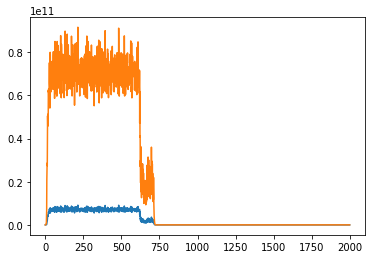

In [70]:
plt.plot(sim.data[actor_test_probe])
plt.plot(sim.data[critic_test_probe])

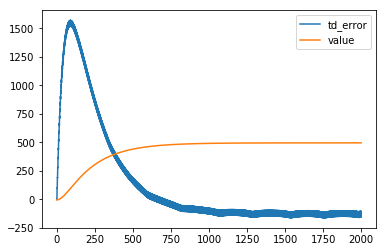

In [71]:
plt.plot(sim.data[err_probe], label='td_error')
plt.plot(sim.data[value_probe], label='value')
plt.legend()

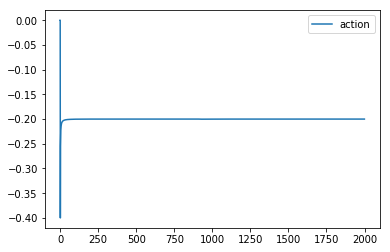

In [67]:
plt.plot(sim.data[action_probe], label='action')
# plt.plot(sim.data[place_probe][:100], label='place')
plt.legend()

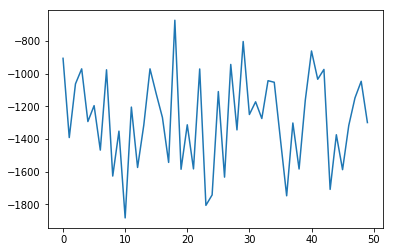

In [56]:
plt.plot(master.reward_history)

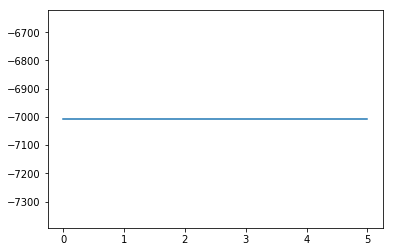

In [51]:
plt.plot(np.convolve(master.reward_history, np.ones(10), 'valid'))

0.0


/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


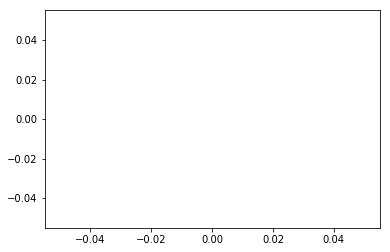

In [14]:
n_actor = 180
w_plus = 30
w_minus = 60
ks = np.arange(n_actor)
actor_lambda = 0.5

denom = 0
k = 0
for k_p in ks:
    if k_p == k: continue
    denom += np.exp(( (k-k_p)/actor_lambda )**2 - 360**2)

ws = np.zeros(n_actor)
for k_p in ks:
    if k == k_p: ws[k_p] = 0
    ws[k_p] = w_minus/n_actor + w_plus + np.exp(( (k-k_p)/actor_lambda )**2  - 360**2)/denom
plt.plot(ks, ws)
print(denom)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

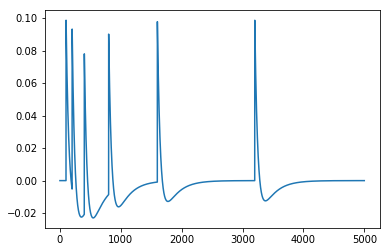

In [56]:
xs = []
def yolo(t, x):
    xs.append(x)

model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if t % 0.1 == 0 else 0 ,size_out=1)
    td_error_node = nengo.Node(yolo, size_in=1)
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
with nengo.Simulator(model) as sim:
    sim.run(5)
    
plt.plot(xs)

In [53]:
gym.make('Pendulum-v0').action_space

/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Box(1,)

In [62]:
n_actor = 180
lamb = 0.5
model = nengo.Network()
a = np.zeros((n_actor,1))
F_max = 2
actor_neurons = []
for k in range(n_actor):
    a[k] = 2*F_max*k / n_actor - F_max
    with model:
        neuron = nengo.Ensemble(1,1)
    actor_neurons.append(neuron)

for k in range(n_actor):
    for k_p in range(n_actor):
        if k == k_p: continue
        lateral_weight = np.exp(-((k - k_p)/lamb)**2)
        if lateral_weight == 0: continue
        print(lateral_weight)
        with model:
            nengo.Connection(actor_neurons[k].neurons,
                             actor_neurons[k_p].neurons,
                             transform=[lateral_weight])
    

0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.3195228302435696e-16
1.1253517471925912e-07


3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294

7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7

7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e

2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251


6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.12535174

7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e

1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-2

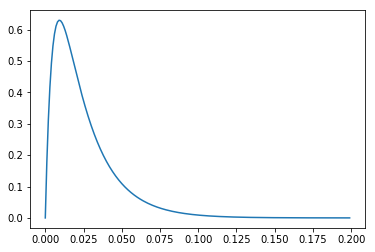

In [37]:
def k(t, v_k=50e-3, tau_k=200e-3):
    return ( np.exp(-t/tau_k) - np.exp(-t/v_k)) / (tau_k-v_k)
ts = np.arange(0,1,1e-3)
# plt.plot(ts, k(ts))

def k_dot(t, v_k=50e-3, tau_k=200e-3):
    return ( -np.exp(-t/tau_k)/tau_k + np.exp(-t/v_k)/v_k) / (tau_k-v_k)
# plt.plot(ts, k_dot(ts))

def epsp(s, eps_zero=20e-3, tau_m=20e-3, tau_s=5e-3):
    return (eps_zero/(tau_m - tau_s))*(np.exp(-s/tau_m)-np.exp(-s/tau_s))*np.heaviside(s, 1)
plt.plot(ts, epsp(ts))

# plt.plot(ts, k_dot(ts) - k(ts)/1)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

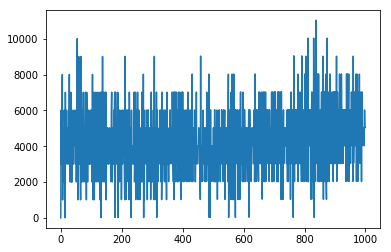

In [84]:
model = nengo.Network()
with model:
    a = nengo.Ensemble(n_neurons=100, dimensions=1)
    b = nengo.Ensemble(n_neurons=50, dimensions=1)
    
w = 2*np.random.randn(b.n_neurons, a.n_neurons)/b.n_neurons
def my_rule(t, x):
    global w
    output = np.dot(w, x)*0.001
    w += np.random.randn(*w.shape)*0.01   # learning rule
    return output

def test(t,x):
    ensemble_spikes = x[:b.n_neurons]
    learner_spikes = x[b.n_neurons:]
    return np.sum(np.abs(ensemble_spikes - learner_spikes))

with model:
    learner = nengo.Node(my_rule, size_in=a.n_neurons,
                         size_out=b.n_neurons)

    nengo.Connection(a.neurons, learner, synapse=None)
    nengo.Connection(learner, b.neurons, synapse=0.05)
    
    test_node = nengo.Node(test, size_in=2*b.n_neurons)
    nengo.Connection(b.neurons, test_node[:b.n_neurons], synapse=None)
    nengo.Connection(learner, test_node[b.n_neurons:], synapse=None)
    
    test_probe = nengo.Probe(test_node, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1)
    
plt.plot(sim.data[test_probe])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

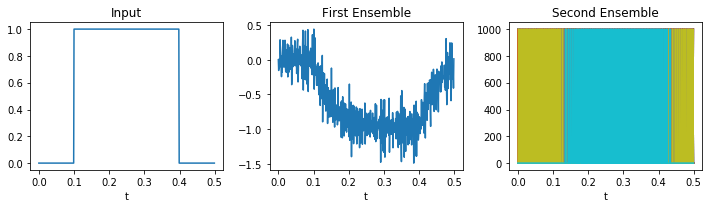

In [4]:
model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if 0.1 < t < 0.4 else 0)
    ens1 = nengo.Ensemble(100,1)
    nengo.Connection(nd_input, ens1, synapse=0.05, transform=-1)
#     nengo.Connection(nd_input, ens1, synapse=0.05, transform=1)
    p0 = nengo.Probe(nd_input)
    p1 = nengo.Probe(ens1)
    p2 = nengo.Probe(ens1.neurons, attr='spikes')
    
dt = 1e-3
T = 0.5
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

ts = np.arange(0,T,dt)
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(ts, sim.data[p0])
ax[0].set_xlabel('t')
ax[0].set_title('Input')
ax[1].plot(ts, sim.data[p1])
ax[1].set_xlabel('t')
ax[1].set_title('First Ensemble')
ax[2].plot(ts, sim.data[p2][:])
ax[2].set_xlabel('t')
ax[2].set_title('Second Ensemble')

plt.tight_layout()

In [20]:
gym.make('Pendulum-v0').action_space.high[0]

/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2.0

In [33]:
import gym
env = gym.make('Pendulum-v0')
for i_episode in range(2):
    observation = env.reset()
    print(observation)
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(action, observation, reward, done, info)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-0.99524326  0.09742102 -0.94515247]
[1.9001162] [-0.99195529  0.12658869 -0.58706928] -9.358980476412551 False {}
[1.4582429] [-0.99013226  0.14013604 -0.27339132] -9.12478696837014 False {}
[0.27122265] [-0.989218    0.14645048 -0.12760589] -9.013511880665973 False {}
[-0.82894635] [-0.98815244  0.15347561 -0.14210998] -8.9700257737185 False {}
[-0.54766226] [-0.98730011  0.15886627 -0.10915261] -8.927523793586813 False {}
[1.032699] [-0.9885764   0.15072058  0.16490194] -8.894882586347396 False {}
[-0.19520128] [-0.99037387  0.13841817  0.24866218] -8.94462463030541 False {}
[-1.5462707] [-0.9911901   0.13244695  0.1205352 ] -9.024953426911042 False {}
[-1.7349908] [-0.99092068  0.1344478  -0.04037821] -9.057072024390596 False {}
[-0.41670015] [-0.99090691  0.13454924 -0.00204739] -9.040800896098512 False {}
[-1.7657808] [-0.98975601  0.14276916 -0.16600258] -9.042967033234678 False {}
[1.4463398] [-0.99085316  0.13494447  0.15802527] -8.994854207252654 False {}
[1.3251952] [-0.993

[0.21516122] [ 0.10701206  0.99425772 -3.04000201] -4.070546783178459 False {}
[0.67214054] [ 0.21519523  0.97657105 -2.19348764] -3.066676387350473 False {}
[-0.54585683] [ 0.28981988  0.95708121 -1.54293788] -2.314494386423214 False {}
[1.5390607] [ 0.3181259   0.94804848 -0.59426786] -1.8705446388564766 False {}
[0.28062582] [0.31058548 0.95054545 0.15886237] -1.590513661399091 False {}
[-0.86707306] [0.27512853 0.96140745 0.7417105 ] -1.5782689558755805 False {}
[1.0684894] [0.19628857 0.98054617 1.6230395 ] -1.7256076012950317 False {}
[-0.6795532] [0.0846442  0.99641124 2.25651615] -2.1496341866264146 False {}
[1.0861369] [-0.07352525  0.99729336  3.16674512] -2.718712962263471 False {}
[0.43398762] [-0.26921931  0.9630789   3.97981328] -3.7070276417519836 False {}
[-0.94211704] [-0.4799718   0.87728392  4.5608049 ] -4.982823787030843 False {}
[-0.23800662] [-0.688759    0.72499038  5.18306685] -6.370926996786336 False {}
[-1.0479667] [-0.86152039  0.50772297  5.56961462] -8.1190